In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_data=pd.read_csv("/content/fnn_train.csv")
test_data=pd.read_csv("/content/fnn_test.csv")
validation_data=pd.read_csv("/content/fnn_dev.csv")

#### Training data which consists of Fake and Real labels

In [ ]:
train_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,Says the Southwest Florida Water Management Di...,['http://www.tampabay.com/news/politics/gubern...,"[""Here's a new one: The Senate budget committe...",Here's a new one: The Senate budget committee ...,fake


In [ ]:
test_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,"""President Obama himself attempted to filibust...",['http://abcnews.go.com/ThisWeek/video/supreme...,['U.S. Supreme Court Justice John Paul Stevens...,U.S. Supreme Court Justice John Paul Stevens a...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,"In Hawaii, ""they don't have a history of throw...",['http://www.starbulletin.com/news/bulletin/94...,"[""On ABC's This Week, the chairmen of the Repu...","On ABC's This Week, the chairmen of the Republ...",real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,"""Our national debt ... is on track to exceed t...",['http://www.desmoinesregister.com/article/201...,['Ever since Barack Obama became president and...,Ever since Barack Obama became president and b...,real


In [ ]:
validation_data.head(3)

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1636,2010-03-28T17:45:34-04:00,Charlie Crist,"Rubio's tax swap proposal ""would have been a m...",['http://blogs.tampabay.com/buzz/files/040307l...,['Gov. Charlie Crist launched what amounts to ...,Gov. Charlie Crist launched what amounts to a ...,fake
1,4352,2011-08-29T06:00:00-04:00,Bobby Scott,"""The estimated savings of this (debt ceiling) ...",['http://www.bobbyscott.house.gov/index.php?op...,"['U.S. Rep. Bobby Scott, D-3rd, was not please...","U.S. Rep. Bobby Scott, D-3rd, was not pleased ...",real
2,16471,2019-02-12T17:35:38-05:00,Wisconsin Republican Legislative leaders,"Foxconn has already ""made a positive impact ac...",['https://www.wispolitics.com/2019/sen-fitzger...,"[""Amid reports questioning Foxconn Technology ...",Amid reports questioning Foxconn Technology Gr...,fake


In [ ]:
train_data.isnull().sum()

id                         0
date                       0
speaker                    0
statement                  0
sources                    0
paragraph_based_content    0
fullText_based_content     0
label_fnn                  0
dtype: int64

#### text without a source doesnt seem promising and can affect the final results, therefore, I decided to remove the nan values which constitutes about '.2%' of the values which is negligible 

In [ ]:
train_data.dropna(inplace=True)

####Cleaning

In [ ]:
processed_features_list = []
def processed_feature_func(data, column):
    for sentence in range(0, len(data)):
    # Remove all the special characters
        processed_feature = re.sub(r'\W', ' ', str(data[column][sentence]))

        # remove all single characters
        processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

        # Remove single characters from the start
        processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

        # Substituting multiple spaces with single space
        processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

        # Removing prefixed 'b'
        processed_feature = re.sub(r'^b\s+', '', processed_feature)
        #making whole text lowercase
        # Converting to Lowercase
        processed_feature = processed_feature.lower()

        processed_features_list.append(processed_feature)

    return(processed_features_list)

In [ ]:
train_data['fullText_based_content']=processed_feature_func(train_data, 'fullText_based_content')

In [ ]:
test_data['fullText_based_content']=processed_feature_func(test_data, 'fullText_based_content')

In [ ]:
train_data

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source,polarity,length
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com,-0.027052,409
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com,-0.062596,571
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com,0.037204,444
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,recently house budget chairman paul ryan wi al...,recently house budget chairman paul ryan wi al...,real,www.cnn.com,0.025027,662
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,say treasury department say 41 percent busines...,millionaire tax proposal make late appearance ...,millionaire tax proposal make late appearance ...,fake,frelinghuysen.house.gov,-0.012354,363
...,...,...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,say veteran disability claim backlog double ob...,legislation file week sen john cornyn tout tex...,legislation file week sen john cornyn tout tex...,real,twitter.com,-0.005159,555
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden laud paul ryan propose cut social s...,sen bernie sander argue former vice president ...,sen bernie sander argue former vice president ...,fake,bernie.substack.com,0.063435,353
15209,16988,2019-06-18T12:06:24-04:00,Viral image,say michael bloomberg say know trump decade tr...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake,www.facebook.com,-0.021023,240
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiation city employee milwaukee mayo...,know labor union stand republican gov scott wa...,know labor union stand republican gov scott wa...,fake,www.wseu-24.org,0.043682,931


In [ ]:
processed_features_list = []
train_data['statement']=(processed_feature_func(train_data, 'statement'))

In [ ]:
processed_features_list = []
test_data['statement']=(processed_feature_func(test_data, 'statement'))

In [ ]:
processed_features_list = []
train_data['paragraph_based_content'] = processed_feature_func(train_data, 'paragraph_based_content')

In [ ]:
processed_features_list = []
test_data['paragraph_based_content'] = processed_feature_func(test_data, 'paragraph_based_content')

In [ ]:
stop = stopwords.words('english')

#### removing stop words from the text

In [ ]:
train_data['fullText_based_content'] = train_data['fullText_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['paragraph_based_content'] = train_data['paragraph_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
train_data['statement'] = train_data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
train_data

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization says georgia one america...,['http://www.ajc.com/news/georgia-politics-ele...,coalition government watchdog groups last week...,coalition government watchdog groups last week...,fake
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,says barack obama health care law biggest job ...,['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,supreme court justices embarked three days ora...,supreme court justices embarked three days ora...,fake
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,says southwest florida water management distri...,['http://www.tampabay.com/news/politics/gubern...,new one senate budget committee chairman says ...,new one senate budget committee chairman says ...,fake
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,['http://www.cnn.com/2011/POLITICS/03/17/gop.b...,recently house budget chairman paul ryan wis a...,recently house budget chairman paul ryan wis a...,real
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,says treasury department says 41 percent busin...,['http://frelinghuysen.house.gov/index.cfm?sec...,millionaires tax proposal made latest appearan...,millionaires tax proposal made latest appearan...,fake
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,says veterans disability claims backlog double...,['https://twitter.com/johncornyn/status/270488...,legislation filed week sen john cornyn touts t...,legislation filed week sen john cornyn touts t...,real
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden lauded paul ryan proposing cuts soc...,['https://bernie.substack.com/p/bern-notice-be...,sen bernie sanders argues former vice presiden...,sen bernie sanders argues former vice presiden...,fake
15209,16988,2019-06-18T12:06:24-04:00,Viral image,says michael bloomberg said known trump decade...,['https://www.facebook.com/liberalamerica.life...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiations city employees milwaukee ma...,['http://www.wseu-24.org/issue_barrett_tom_201...,know labor unions stand republican gov scott w...,know labor unions stand republican gov scott w...,fake


In [ ]:
test_data['fullText_based_content'] = test_data['fullText_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['paragraph_based_content'] = test_data['paragraph_based_content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_data['statement'] = test_data['statement'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Below code was taken from advertools in order to sort the url and achieve the target https://advertools.readthedocs.io/en/master/_modules/advertools/urlytics.html

In [ ]:
from urllib.parse import urlsplit, parse_qs, unquote

import pandas as pd


def url_to_df(urls, decode=True):
    """Split the given URLs into their components to a DataFrame.

    Each column will have its own component, and query parameters and
    directories will also be parsed and given special columns each.

    :param url urls: A list of URLs to split into components
    :param bool decode: Whether or not to decode the given URLs
    :return DataFrame split: A DataFrame with a column for each component
    """
    if isinstance(urls, str):
        urls = [urls]
    decode = unquote if decode else lambda x: x
    split_list = []
    for url in urls:
        split = urlsplit(decode(url))
        port = split.port
        hostname = split.hostname if split.hostname != split.netloc else None
        split = split._asdict()
        if hostname:
            split['hostname'] = hostname
        if port:
            split['port'] = port
        parsed_query = parse_qs(split['query'])
        parsed_query = {'query_' + key: '@@'.join(val)
                        for key, val in parsed_query.items()}
        split.update(**parsed_query)
        dirs = split['path'].strip('/').split('/')
        if dirs[0]:
            dir_cols = {'dir_{}'.format(n): d for n, d in enumerate(dirs, 1)}
            split.update(**dir_cols)
        split_list.append(split)
    df = pd.DataFrame(split_list)

    query_df = df.filter(regex='query_')
    if not query_df.empty:
        df = df.drop(query_df.columns, axis=1)
    dirs_df = df.filter(regex='dir_')
    if not dirs_df.empty:
        df = df.drop(dirs_df.columns, axis=1)
    df = pd.concat([df, dirs_df, query_df], axis=1)
    df.insert(0, 'url', [decode(url) for url in urls])
    return df

In [ ]:
url_to_df(train_data['sources'][1])

,url,scheme,netloc,path,query,fragment,dir_1,dir_2,dir_3,dir_4,query_v,query_feature
0,['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,,,['http://www.youtube.com/watch,"v=TaC0mKApf9Q&feature=youtu.be', 'http://www.p...","fl', 'http://www.tampabay.com/blogs/the-buzz-f...",['http:,,www.youtube.com,watch,TaC0mKApf9Q,"youtu.be', 'http://www.politifact.com/truth-o-..."


In [ ]:
url_df=url_to_df(train_data['sources'])

In [ ]:
url_testdf=url_to_df(test_data['sources'])

In [ ]:
url_df['dir_3'].nunique()

3554

In [ ]:
url_testdf['dir_3'].nunique()

571

In [ ]:
from collections import Counter
import collections

In [ ]:
counts_directory=collections.Counter(url_df['dir_3'])

In [ ]:
counts_directory.most_common(10)

[('www.youtube.com', 1537),
 ('www.facebook.com', 928),
 ('twitter.com', 721),
 ('www.politifact.com', 563),
 ('www.whitehouse.gov', 278),
 (nan, 273),
 ('docs.google.com', 269),
 ('abcnews.go.com', 194),
 ('www.washingtonpost.com', 188),
 ('www.c-span.org', 168)]

In [ ]:
train_data['source']=url_df['dir_3']

In [ ]:
test_data['source']=url_testdf['dir_3']

In [ ]:
train_data.drop('sources', inplace=True, axis=1)

In [ ]:
test_data.drop('sources', inplace=True, axis=1)

In [ ]:
test_data.head(3)

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,president obama attempt filibuster justice ali...,supreme court justice john paul stevens announ...,supreme court justice john paul stevens announ...,real,abcnews.go.com
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,hawaii history throw incumbent office,abc week chairman republican democratic nation...,abc week chairman republican democratic nation...,real,www.starbulletin.com
2,1624,2010-03-26T10:24:21-04:00,John Boehner,national debt track exceed size entire economy...,ever since barack obama become president begin...,ever since barack obama become president begin...,real,www.desmoinesregister.com


In [ ]:
df_url_counts = pd.DataFrame(counts_directory.most_common(20),
                             columns=['url', 'count'])

df_url_counts.head()

,url,count
0,www.youtube.com,1537
1,www.facebook.com,928
2,twitter.com,721
3,www.politifact.com,563
4,www.whitehouse.gov,278


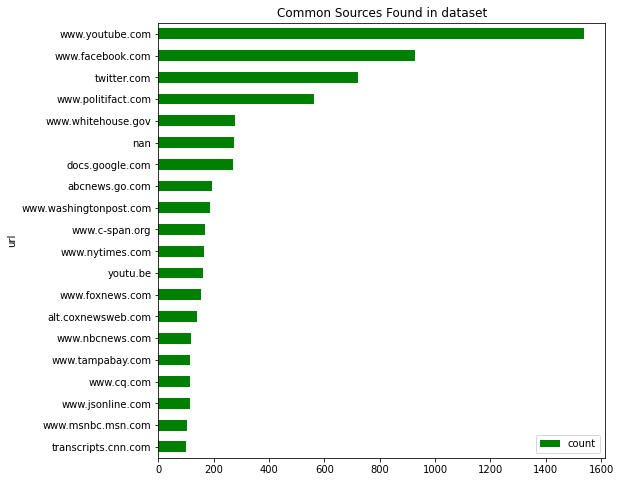

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_url_counts.sort_values(by='count').plot.barh(x='url',
                      y='count',
                      ax=ax,
                      color="green")

ax.set_title("Common Sources Found in dataset")

plt.show()

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
lemmatizer = WordNetLemmatizer()

### Lemmatized text

In [ ]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
   
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        elif len(word)>2:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
for sentence in range(len(train_data)):
    train_data['fullText_based_content'][sentence]=lemmatize_sentence(train_data['fullText_based_content'][sentence])
    train_data['paragraph_based_content'][sentence]=lemmatize_sentence(train_data['paragraph_based_content'][sentence])
    train_data['statement'][sentence]=lemmatize_sentence(train_data['statement'][sentence])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from 

In [ ]:
train_data

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,recently house budget chairman paul ryan wi al...,recently house budget chairman paul ryan wi al...,real,www.cnn.com
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,say treasury department say 41 percent busines...,millionaire tax proposal make late appearance ...,millionaire tax proposal make late appearance ...,fake,frelinghuysen.house.gov
...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,say veteran disability claim backlog double ob...,legislation file week sen john cornyn tout tex...,legislation file week sen john cornyn tout tex...,real,twitter.com
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden laud paul ryan propose cut social s...,sen bernie sander argue former vice president ...,sen bernie sander argue former vice president ...,fake,bernie.substack.com
15209,16988,2019-06-18T12:06:24-04:00,Viral image,say michael bloomberg say know trump decade tr...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake,www.facebook.com
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiation city employee milwaukee mayo...,know labor union stand republican gov scott wa...,know labor union stand republican gov scott wa...,fake,www.wseu-24.org


In [ ]:
for sentence in range(len(test_data)):
    test_data['fullText_based_content'][sentence]=lemmatize_sentence(test_data['fullText_based_content'][sentence])
    test_data['paragraph_based_content'][sentence]=lemmatize_sentence(test_data['paragraph_based_content'][sentence])
    test_data['statement'][sentence]=lemmatize_sentence(test_data['statement'][sentence])

In [ ]:
test_data

,id,date,speaker,statement,sources,paragraph_based_content,fullText_based_content,label_fnn
0,1678,2010-04-11T16:37:40-04:00,Jon Kyl,president obama attempt filibuster justice ali...,['http://abcnews.go.com/ThisWeek/video/supreme...,supreme court justice john paul stevens announ...,supreme court justice john paul stevens announ...,real
1,1820,2010-05-23T18:11:09-04:00,Michael Steele,hawaii history throw incumbent office,['http://www.starbulletin.com/news/bulletin/94...,abc week chairman republican democratic nation...,abc week chairman republican democratic nation...,real
2,1624,2010-03-26T10:24:21-04:00,John Boehner,national debt track exceed size entire economy...,['http://www.desmoinesregister.com/article/201...,ever since barack obama become president begin...,ever since barack obama become president begin...,real
3,1576,2010-03-12T11:45:14-05:00,America's Health Insurance Plans,health insurance company cost 4 percent health...,"['http://www.youtube.com/watch?v=4O8CxZ1OD58',...",battle health care reform approach climax amer...,battle health care reform approach climax amer...,real
4,1770,2010-05-07T11:54:44-04:00,Michael Bloomberg,prevent terror suspect board airplane fbi powe...,['http://www.huffingtonpost.com/michael-bloomb...,wake foil car bomb attempt time square new yor...,wake foil car bomb attempt time square new yor...,real
...,...,...,...,...,...,...,...,...
1049,12070,2016-03-15T16:36:20-04:00,Hillary Clinton,gun violence far leading cause death young afr...,['https://medium.com/hillary-for-america/break...,speech post medium democratic presidential can...,speech post medium democratic presidential can...,real
1050,10423,2015-01-21T16:21:46-05:00,Barack Obama,economy create job fast pace since 1999,['http://data.bls.gov/cgi-bin/surveymost?ln'],president barack obama state union address not...,president barack obama state union address not...,real
1051,12017,2016-03-08T12:51:40-05:00,Right to Rise,like marco rubio sen barack obama one bad atte...,"['https://youtu.be/uRqSUv_B7KI', 'https://www....",commercial super pac right rise usa show silho...,commercial super pac right rise usa show silho...,real
1052,12120,2016-03-24T15:00:45-04:00,Bernie Sanders,bernie sander pass roll call amendment republi...,['http://politicaladarchive.org/ad/PolAd_Berni...,bernie sander often criticize pie sky proposal...,bernie sander often criticize pie sky proposal...,real


In [ ]:
words_in_dataset=[words.split() for words in train_data['statement']]

In [ ]:
len(words_in_dataset)

15212

In [ ]:
just_words=[]
for i in words_in_dataset:
  for j in i:
    just_words.append(j)

In [ ]:
len(just_words)

172826

https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

In [ ]:
from matplotlib import rcParams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
wordcloud = WordCloud(background_color="white", max_words=274).generate(str(just_words))

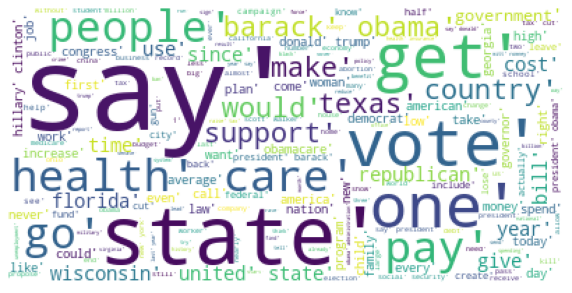

In [ ]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
counts=collections.Counter(just_words)

In [ ]:
counts.most_common(25)

[('say', 4903),
 ('state', 2002),
 ('year', 1781),
 ('percent', 1605),
 ('tax', 1497),
 ('obama', 1110),
 ('000', 1078),
 ('people', 1036),
 ('president', 1003),
 ('million', 957),
 ('job', 867),
 ('vote', 865),
 ('health', 858),
 ('one', 776),
 ('would', 755),
 ('care', 722),
 ('pay', 719),
 ('new', 717),
 ('american', 700),
 ('get', 693),
 ('time', 688),
 ('bill', 670),
 ('billion', 659),
 ('country', 650),
 ('1', 633)]

In [ ]:
df_counts = pd.DataFrame(counts.most_common(25),
                             columns=['words', 'count'])

df_counts.head()

,words,count
0,say,4903
1,state,2002
2,year,1781
3,percent,1605
4,tax,1497


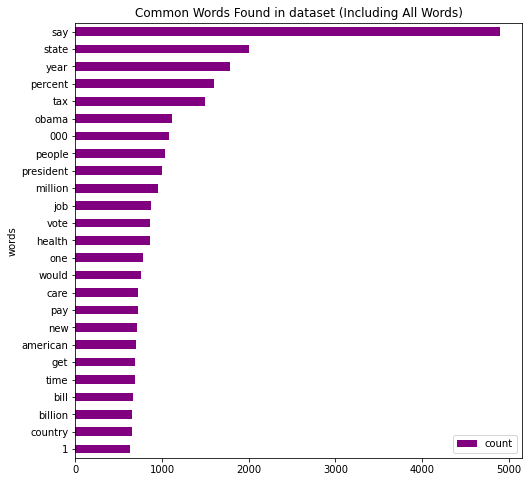

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_counts.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in dataset (Including All Words)")

plt.show()

In [ ]:
counts_label=collections.Counter(train_data['label_fnn'])

In [ ]:
counts_label

Counter({'fake': 7621, 'real': 7591})

In [ ]:
df_label_counts = pd.DataFrame(counts_label.most_common(2), columns=['label', 'count'])

df_label_counts.head()

,label,count
0,fake,7621
1,real,7591


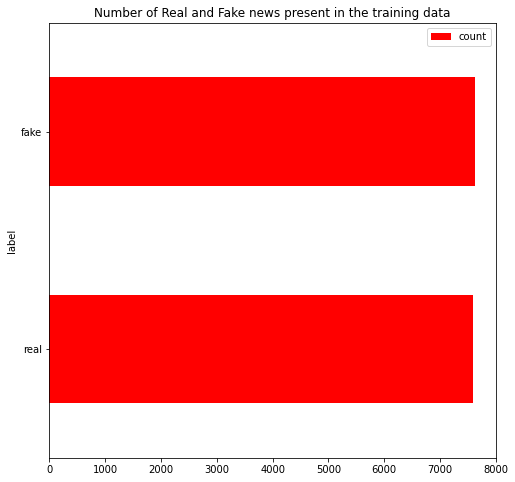

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
df_label_counts.sort_values(by='count').plot.barh(x='label',
                      y='count',
                      ax=ax,
                      color="red")

ax.set_title("Number of Real and Fake news present in the training data")

plt.show()

In [ ]:
train_data.columns

Index(['id', 'date', 'speaker', 'statement', 'paragraph_based_content',
       'fullText_based_content', 'label_fnn', 'source'],
      dtype='object')

In [ ]:
from textblob import TextBlob
import plotly.figure_factory as ff

https://plotly.com/python/figure-factory-subplots/

### Below cell is to test out the polarity of the text, the polarity is between the range [-1,1]. -1 being the worst and 1 being the best. According to analysis we can see that all the text are neutral. 

### X-axis shows the length of the articles, we can see that most of the articles are in the range of 0 to 1000 words.

In [ ]:
train_data['polarity'] = train_data['fullText_based_content'].map(lambda text: TextBlob(text).sentiment.polarity)

def text_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data['length'] = train_data['fullText_based_content'].apply(text_len)
nums_text = train_data.query('length > 0')['length']

fig = ff.create_distplot(hist_data = [nums_text], group_labels = ['fullText_based_content'])
fig.update_layout(title_text='Distribution of article length', template="plotly_white")
fig.show()

In [ ]:
import gensim

### performing topic modeling on first 100 sentences of the statement column of train_data dataset to check how the data is reacting.

https://stackoverflow.com/questions/33229360/gensim-typeerror-doc2bow-expects-an-array-of-unicode-tokens-on-input-not-a-si

In [ ]:
for sentence in range(0, 100):
    corpus = lemmatize_sentence(train_data['statement'][sentence])
    #print(corpus)
    corpus = [corpus.split(' ')]
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                      num_topics = 4, 
                                      id2word = dic,                                    
                                      passes = 10,
                                      workers = 2)
lda_model.show_topics()

[(0,
  '0.100*"protection" + 0.100*"regulation" + 0.100*"jan" + 0.100*"agency" + 0.100*"regulates" + 0.100*"effect" + 0.100*"1" + 0.100*"2012" + 0.100*"dust" + 0.100*"environmental"'),
 (1,
  '0.100*"2012" + 0.100*"environmental" + 0.100*"dust" + 0.100*"agency" + 0.100*"regulates" + 0.100*"jan" + 0.100*"effect" + 0.100*"regulation" + 0.100*"protection" + 0.100*"1"'),
 (2,
  '0.100*"dust" + 0.100*"1" + 0.100*"2012" + 0.100*"effect" + 0.100*"regulates" + 0.100*"regulation" + 0.100*"environmental" + 0.100*"agency" + 0.100*"jan" + 0.100*"protection"'),
 (3,
  '0.100*"environmental" + 0.100*"dust" + 0.100*"1" + 0.100*"effect" + 0.100*"2012" + 0.100*"protection" + 0.100*"jan" + 0.100*"agency" + 0.100*"regulation" + 0.100*"regulates"')]

In [ ]:
train_data.head(3)

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source,polarity,length
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com,-0.027052,409
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com,-0.062596,571
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com,0.037204,444


In [ ]:
train_data.isnull().sum()

id                           0
date                         0
speaker                      0
statement                    0
paragraph_based_content      0
fullText_based_content       0
label_fnn                    0
source                     273
polarity                     0
length                       0
dtype: int64

In [ ]:
train_data.dropna()

,id,date,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source,polarity,length
0,3106,2011-01-25T06:00:00-05:00,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com,-0.027052,409
1,5655,2012-04-02T11:42:20-04:00,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com,-0.062596,571
2,3506,2011-04-01T09:49:05-04:00,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com,0.037204,444
3,3450,2011-03-21T12:20:02-04:00,Paul Ryan,congressional budget office economic model mea...,recently house budget chairman paul ryan wi al...,recently house budget chairman paul ryan wi al...,real,www.cnn.com,0.025027,662
4,4776,2011-11-13T07:30:00-05:00,Rodney Frelinghuysen,say treasury department say 41 percent busines...,millionaire tax proposal make late appearance ...,millionaire tax proposal make late appearance ...,fake,frelinghuysen.house.gov,-0.012354,363
...,...,...,...,...,...,...,...,...,...,...
15207,7125,2012-11-28T16:57:04-05:00,John Cornyn,say veteran disability claim backlog double ob...,legislation file week sen john cornyn tout tex...,legislation file week sen john cornyn tout tex...,real,twitter.com,-0.005159,555
15208,17742,2020-01-09T15:05:09-05:00,Bernie Sanders,2018 biden laud paul ryan propose cut social s...,sen bernie sander argue former vice president ...,sen bernie sander argue former vice president ...,fake,bernie.substack.com,0.063435,353
15209,16988,2019-06-18T12:06:24-04:00,Viral image,say michael bloomberg say know trump decade tr...,ready billionaire talk recent facebook post la...,ready billionaire talk recent facebook post la...,fake,www.facebook.com,-0.021023,240
15210,5758,2012-04-18T09:00:00-04:00,AFSCME,labor negotiation city employee milwaukee mayo...,know labor union stand republican gov scott wa...,know labor union stand republican gov scott wa...,fake,www.wseu-24.org,0.043682,931


In [ ]:
train_data.drop(columns=['date'], inplace=True)

In [ ]:
test_data.drop(columns=['date'], inplace=True)

In [ ]:
train_data.head(3)

,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source,polarity,length
0,Joe Wilkinson,national organization say georgia one america ...,coalition government watchdog group last week ...,coalition government watchdog group last week ...,fake,www.ajc.com,-0.027052,409
1,Rick Scott,say barack obama health care law big job kille...,supreme court justice embark three day oral ar...,supreme court justice embark three day oral ar...,fake,www.youtube.com,-0.062596,571
2,J.D. Alexander,say southwest florida water management distric...,new one senate budget committee chairman say w...,new one senate budget committee chairman say w...,fake,www.tampabay.com,0.037204,444


https://stackoverflow.com/questions/53898836/export-dataframe-as-csv-file-from-google-colab-to-google-drive/60733479

In [ ]:
train_data.to_csv('cleaned_data.csv')

In [ ]:
test_data.to_csv('cleanedTest_data.csv')

In [ ]:
!cp cleaned_data.csv "drive/My Drive/"

In [ ]:
!cp cleanedTest_data.csv "drive/My Drive/"

In [ ]:
from_drive = pd.read_csv('cleanedTest_data.csv')

In [ ]:
from_drive

,Unnamed: 0,speaker,statement,paragraph_based_content,fullText_based_content,label_fnn,source
0,0,Jon Kyl,president obama attempt filibuster justice ali...,supreme court justice john paul stevens announ...,supreme court justice john paul stevens announ...,real,abcnews.go.com
1,1,Michael Steele,hawaii history throw incumbent office,abc week chairman republican democratic nation...,abc week chairman republican democratic nation...,real,www.starbulletin.com
2,2,John Boehner,national debt track exceed size entire economy...,ever since barack obama become president begin...,ever since barack obama become president begin...,real,www.desmoinesregister.com
3,3,America's Health Insurance Plans,health insurance company cost 4 percent health...,battle health care reform approach climax amer...,battle health care reform approach climax amer...,real,www.youtube.com
4,4,Michael Bloomberg,prevent terror suspect board airplane fbi powe...,wake foil car bomb attempt time square new yor...,wake foil car bomb attempt time square new yor...,real,www.huffingtonpost.com
...,...,...,...,...,...,...,...
1049,1049,Hillary Clinton,gun violence far leading cause death young afr...,speech post medium democratic presidential can...,speech post medium democratic presidential can...,real,medium.com
1050,1050,Barack Obama,economy create job fast pace since 1999,president barack obama state union address not...,president barack obama state union address not...,real,data.bls.gov
1051,1051,Right to Rise,like marco rubio sen barack obama one bad atte...,commercial super pac right rise usa show silho...,commercial super pac right rise usa show silho...,real,youtu.be
1052,1052,Bernie Sanders,bernie sander pass roll call amendment republi...,bernie sander often criticize pie sky proposal...,bernie sander often criticize pie sky proposal...,real,politicaladarchive.org
